<a href="https://colab.research.google.com/github/githubforkj/signate/blob/main/mufj/03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 遊んでみるファイル

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/signate/mufj/Input/train.csv')
test = pd.read_csv('/content/drive/MyDrive/signate/mufj/Input/test.csv')

In [ ]:
print(train.isnull().value_counts())
print('---------------------------------------------------------')
print(test.isnull().value_counts())
# 欠損値がないことを確認

id     goal   country  duration  category1  category2  html_content  state
False  False  False    False     False      False      False         False    9791
dtype: int64
---------------------------------------------------------
id     goal   country  duration  category1  category2  html_content
False  False  False    False     False      False      False           9800
dtype: int64


In [ ]:
train.head()

,id,goal,country,duration,category1,category2,html_content,state
0,train_00000,20001-21000,US,45,art,mixed media,"<div class=""contents""><div><p><a href=""http://...",1
1,train_00001,19001-20000,US,59,food,restaurants,"<div class=""contents""><div><p>Cultural Pretzel...",0
2,train_00002,2001-3000,US,38,art,performance art,"<div class=""contents""><div><p>I want to perfor...",0
3,train_00003,1001-2000,US,30,art,mixed media,"<div class=""contents""><div><div class=""templat...",1
4,train_00004,1001-2000,US,29,film & video,webseries,"<div class=""contents""><div><p>The story of the...",1


In [ ]:
from sklearn.preprocessing import LabelEncoder

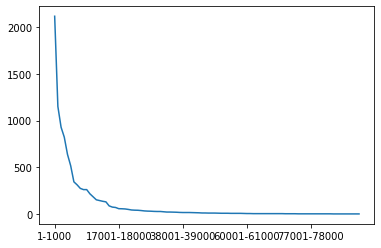

In [ ]:
train['goal'].value_counts().plot()
# 10個ほどの質的変数に変更できれば、one-hotエンコーディングできるのでは？

In [ ]:
train['goal'].categori

In [ ]:
print(train[train['goal']=='17001-18000'].count())
print(train[train['goal']=='18001-19000'].count())
print(train[train['goal']=='19001-20000'].count())
print(train[train['goal']=='20001-21000'].count())
print(train[train['goal']=='21001-22000'].count())
print(train[train['goal']=='22001-23000'].count())
print(train[train['goal']=='39001-40000'].count())

# 20001以降はまとめて良いのでは？

id              57
goal            57
country         57
duration        57
category1       57
category2       57
html_content    57
state           57
dtype: int64
id              31
goal            31
country         31
duration        31
category1       31
category2       31
html_content    31
state           31
dtype: int64
id              216
goal            216
country         216
duration        216
category1       216
category2       216
html_content    216
state           216
dtype: int64
id              21
goal            21
country         21
duration        21
category1       21
category2       21
html_content    21
state           21
dtype: int64
id              37
goal            37
country         37
duration        37
category1       37
category2       37
html_content    37
state           37
dtype: int64
id              33
goal            33
country         33
duration        33
category1       33
category2       33
html_content    33
state           33
dtype: int64
id

1-1000         2115
1001-2000      1150
2001-3000       928
4001-5000       822
3001-4000       638
               ... 
96001-97000       1
68001-69000       1
93001-94000       1
91001-92000       1
82001-83000       1
Name: goal, Length: 96, dtype: int64


In [ ]:
train.drop('id')

9791

In [ ]:
train_x = train.drop(['id'], axis = 1)


# goalカラムは順序尺度のため、one-hot encodingを適用
# country,category1,2は名義尺度のため、label encodingを適用